In [61]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import re
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
staff = pd.read_csv("../staff_data/staff_raceeth_jobcategories_2010_2015.csv")
students = pd.read_csv("../student_data/student_raceeth_all.csv")
enrollment = pd.read_csv("../student_data/student_enrollment_all.csv", usecols = ["Org Code", "Year", "TOTAL"])
addresses = pd.read_csv("../student_data/school_addresses.csv", encoding = "ISO-8859-1", converters={'Zip Code': str}, usecols = ["Org Code", "Org Name", "Org Type", "Town", "Zip Code", "Grades"])
acs = pd.read_csv("../acs/acs_indicators_by_zip.csv", converters={'Zip Code': str}, usecols = ["Zip Code", "Median Income", "Percent Poverty", "% HS Graduates", "% College Graduates"])

In [5]:
# Remove "-"
acs = acs.replace('-', np.NaN)

In [6]:
students.columns

Index(['Org Code', 'SCHOOL', 'African American', 'Asian', 'Hispanic', 'White',
       'Native American', 'Native Hawaiian, Pacific Islander',
       'Multi-Race, Non-Hispanic', 'Males', 'Females', 'Source', 'Year'],
      dtype='object')

In [7]:
acs["Median Income"] = acs["Median Income"].apply(pd.to_numeric, errors='coerce')
acs["Percent Poverty"] = acs["Percent Poverty"].apply(pd.to_numeric, errors='coerce')

In [ ]:
# Calculate student numbers and staff percents

In [8]:
enrollment = enrollment.rename(columns={"TOTAL": "Total Students"})

In [9]:
students = pd.merge(students, enrollment, on = ["Org Code", "Year"])

In [10]:
students['Nonwhite (Num Stu)'] = students["Total Students"] - (round(students['White']/100 * students['Total Students'], 0))

In [11]:
staff['Nonwhite (Num Staff)'] = staff["FTE Count"] - staff["White (# )"]

In [12]:
staff.columns

Index(['Org Code', 'Job Group', 'Year', 'SCHOOL', 'African American (# )',
       'Asian (# )', 'Hispanic (# )', 'White (# )', 'FTE Count', 'Other (# )',
       'Job Category', 'Nonwhite (Num Staff)'],
      dtype='object')

In [13]:
df = pd.merge(students, staff, how= "left", on= ['Org Code','Year'])

In [14]:
df.columns

Index(['Org Code', 'SCHOOL_x', 'African American', 'Asian', 'Hispanic',
       'White', 'Native American', 'Native Hawaiian, Pacific Islander',
       'Multi-Race, Non-Hispanic', 'Males', 'Females', 'Source', 'Year',
       'Total Students', 'Nonwhite (Num Stu)', 'Job Group', 'SCHOOL_y',
       'African American (# )', 'Asian (# )', 'Hispanic (# )', 'White (# )',
       'FTE Count', 'Other (# )', 'Job Category', 'Nonwhite (Num Staff)'],
      dtype='object')

In [15]:
df = df[["Org Code", "Year", "Job Category", "Nonwhite (Num Stu)", "Total Students", "Nonwhite (Num Staff)", "FTE Count"]]

In [38]:
df_job_mask = df["Org Code"] == 0
df_jobs = df[~df_job_mask]

In [47]:
df_jobs_grouped = df_jobs.groupby("Job Category").sum()[["Nonwhite (Num Staff)", "FTE Count"]]

In [49]:
df_jobs_grouped["% Nonwhite Staff"] = round(df_jobs_grouped["Nonwhite (Num Staff)"] / df_jobs_grouped["FTE Count"] * 100, 1)

In [50]:
df_jobs_grouped

,Nonwhite (Num Staff),FTE Count,% Nonwhite Staff
Job Category,,,
Administrative Support,3441.8,34812.7,9.9
All Staff,57309.0,700509.3,8.2
District Leaders,162.8,2183.4,7.5
Health,551.5,11358.7,4.9
Paraprofessionals,16515.2,138875.7,11.9
Related Service Providers,727.6,19963.2,3.6
School Leaders,2946.0,26338.1,11.2
Student Support,3280.6,38792.9,8.5
Teachers,29692.8,428439.0,6.9


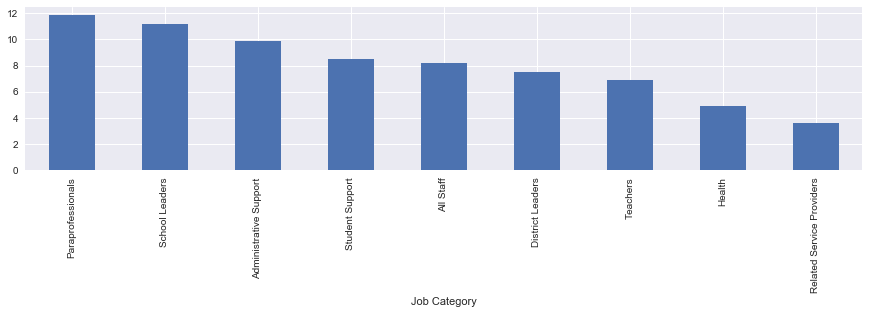

In [62]:
job = df_jobs_grouped["% Nonwhite Staff"].sort_values(ascending = False).plot(kind = "bar", figsize = (15, 3))

In [17]:
staff_mask = df["Job Category"] == "All Staff"
df_staff = df[staff_mask]

In [18]:
df_zip = pd.merge(df_staff, addresses, how = "inner", on = "Org Code")
df_zip = df_zip.fillna(0)

In [19]:
zip_grouped = df_zip.groupby("Zip Code").sum()[["Nonwhite (Num Stu)", "Total Students", "Nonwhite (Num Staff)", "FTE Count"]]

In [20]:
zip_grouped['Perc Nonwhite Students'] = zip_grouped['Nonwhite (Num Stu)'] / zip_grouped['Total Students'] * 100
zip_grouped['Perc Nonwhite Staff'] = zip_grouped['Nonwhite (Num Staff)'] / zip_grouped['FTE Count'] * 100

In [21]:
zip_grouped = zip_grouped.reset_index()

In [22]:
df_zip = pd.merge(zip_grouped, acs, how = "inner", on = "Zip Code")

In [23]:
df_zip.columns

Index(['Zip Code', 'Nonwhite (Num Stu)', 'Total Students',
       'Nonwhite (Num Staff)', 'FTE Count', 'Perc Nonwhite Students',
       'Perc Nonwhite Staff', 'Median Income', 'Percent Poverty',
       '% HS Graduates', '% College Graduates'],
      dtype='object')

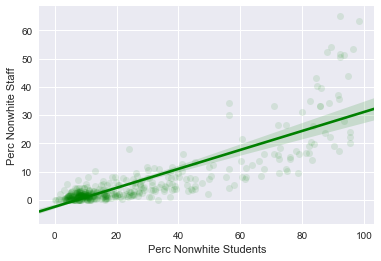

In [24]:
sns.regplot(x = "Perc Nonwhite Students", y = "Perc Nonwhite Staff", data = df_zip, color="green", scatter_kws = {"alpha" : 0.1,});

In [25]:
ols = smf.ols(formula = "perc_nw_staff ~ perc_nw_stu + hs_grad + med_income + college_grad + perc_poverty",
              data = df_zip.rename(columns = {"Perc Nonwhite Students" : "perc_nw_stu", 
                                              "Perc Nonwhite Staff"  : "perc_nw_staff",
                                              "Median Income": "med_income",
                                              "Percent Poverty": "perc_poverty",
                                              "% HS Graduates": "hs_grad",
                                             "% College Graduates": "college_grad" }))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          perc_nw_staff   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     196.2
Date:                Mon, 27 Nov 2017   Prob (F-statistic):          5.12e-107
Time:                        15:02:41   Log-Likelihood:                -1327.4
No. Observations:                 422   AIC:                             2667.
Df Residuals:                     416   BIC:                             2691.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -10.1915      6.950     -1.466      0.143     -23.854       3.471
perc_nw_stu      0.3312      0.017     19.583      0.000       0.298       0.364
hs_grad          0.0690      0.077      0.901      0.368      -0.081       0.219
med_income   -2.532e-05   1.73e-05     -1.464      0.144   -5.93e-05    8.68e-06
college_grad     0.0729      0.030      2.450      0.015       0.014       0.131
perc_poverty     0.0411      0.040      1.016      0.310      -0.038       0.121
==============================================================================
Omnibus:                      225.107   Durbin-Watson:                   0.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2174.104
Skew:                           2.081   Prob(JB):                         0.00
Kurtosis:                      13.311   Cond. No.                     2.10e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
sns.regplot(x = df_zip["Perc Nonwhite Students"], y = pd.Series(model.resid, name = "Residual"), scatter_kws = {"alpha" : 0.1});

In [60]:
year_grouped = df_staff.groupby("Year").sum()[["Nonwhite (Num Stu)", "Total Students", "Nonwhite (Num Staff)", "FTE Count"]]

ValueError: No axis named Org Type for object type <class 'pandas.core.frame.DataFrame'>

In [34]:
year_grouped['Perc Nonwhite Students'] = year_grouped['Nonwhite (Num Stu)'] / year_grouped['Total Students'] * 100
year_grouped['Perc Nonwhite Staff'] = year_grouped['Nonwhite (Num Staff)'] / year_grouped['FTE Count'] * 100

In [35]:
year_grouped = year_grouped.reset_index()

In [59]:
year_grouped

,Year,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),FTE Count,Perc Nonwhite Students,Perc Nonwhite Staff
0,2010,295749.0,957053,9377.4,115464.0,30.902050,8.121492
1,2011,305397.0,955563,9381.1,114390.6,31.959902,8.200936
2,2012,314257.0,953369,9354.6,115053.3,32.962788,8.130666
3,2013,324629.0,954771,9775.4,117215.0,34.000718,8.339718
4,2014,334997.0,955507,9464.7,118299.0,35.059607,8.000659
5,2015,347382.0,955843,9955.8,120087.4,36.342998,8.290462


(0, 50)

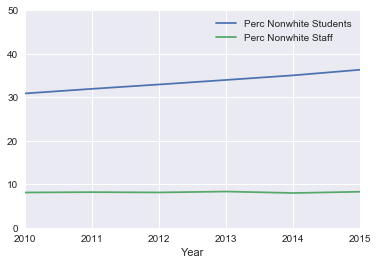

In [36]:
ax = year_grouped[['Year','Perc Nonwhite Students', 'Perc Nonwhite Staff']].set_index('Year').plot()
ax.set_ylim(ymin = 0, ymax = 50)